Задание:
Скачать датасет по ссылке (снимки и маски, Version 1) . Обучить нейронную сеть предсказывать полноразмерную маску по загруженному снимку

Этап 1. Обработка исходных данных. Разделение на обучающую и тестовую выборку

In [1]:
import os
import cv2
import numpy as np
import glob

import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
sm.set_framework('tf.keras')
from tensorflow.keras.metrics import MeanIoU
import random

from pathlib import Path
from imutils.paths import list_images

from tqdm import tqdm

import imagecodecs

Segmentation Models: using `keras` framework.


1.1. Проверка вывода растра и масок

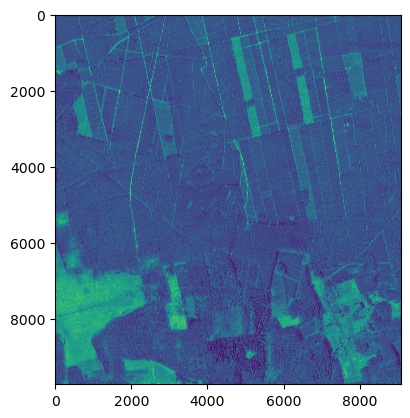

In [2]:
temp_img = tiff.imread('datasets/landcover/images/M-33-7-A-d-2-3.tif')
plt.imshow(temp_img[:,:,0])

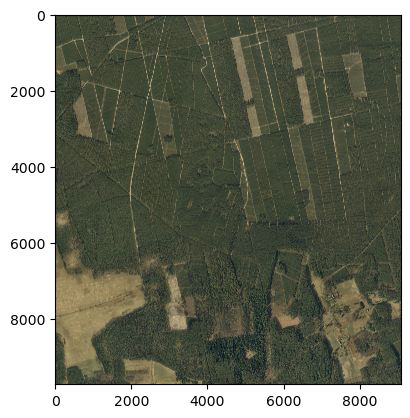

In [3]:
temp_mask = tiff.imread('datasets/landcover/images/M-33-7-A-d-2-3.tif')
plt.imshow(temp_mask)

In [4]:
print(temp_img.shape)
print(temp_img.dtype)
print(temp_mask.shape)

(9711, 9081, 3)
uint8
(9711, 9081, 3)


1.2. Обрезка исходных растров на фрагменты (патчи) размером 256x256. Сохраните их в каталог на локальное хранилице

In [5]:
dataset_dir = 'datasets/landcover'
patch_size = 256

In [12]:
image_dataset = []

for image_name in os.listdir(f'{dataset_dir}/images'):
    if image_name.endswith(".tif"):
        image = tiff.imread(f'{dataset_dir}/images/{image_name}')

        SIZE_X = (image.shape[1] // patch_size) * patch_size
        SIZE_Y = (image.shape[0] // patch_size) * patch_size

        image = image[0:SIZE_Y, 0:SIZE_X]

        print("Now patchifying image:", f'{image_name}')
        patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                single_patch_img = single_patch_img[0]

                os.makedirs(f'{dataset_dir}/256_patches/images', exist_ok=True)
                tiff.imwrite(f'{dataset_dir}/256_patches/images/{image_name}_patch_{i}{j}.tif', single_patch_img, photometric='rgb')
                image_dataset.append(f'{dataset_dir}/256_patches/images/{image_name}_patch_{i}{j}.tif')

Now patchifying image: M-33-20-D-c-4-2.tif
Now patchifying image: M-33-20-D-d-3-3.tif
Now patchifying image: M-33-32-B-b-4-4.tif
Now patchifying image: M-33-48-A-c-4-4.tif
Now patchifying image: M-33-7-A-d-2-3.tif
Now patchifying image: M-33-7-A-d-3-2.tif
Now patchifying image: M-34-32-B-a-4-3.tif
Now patchifying image: M-34-32-B-b-1-3.tif
Now patchifying image: M-34-5-D-d-4-2.tif
Now patchifying image: M-34-51-C-b-2-1.tif
Now patchifying image: M-34-51-C-d-4-1.tif
Now patchifying image: M-34-55-B-b-4-1.tif
Now patchifying image: M-34-56-A-b-1-4.tif
Now patchifying image: M-34-6-A-d-2-2.tif
Now patchifying image: M-34-65-D-a-4-4.tif
Now patchifying image: M-34-65-D-c-4-2.tif
Now patchifying image: M-34-65-D-d-4-1.tif
Now patchifying image: M-34-68-B-a-1-3.tif
Now patchifying image: M-34-77-B-c-2-3.tif
Now patchifying image: N-33-104-A-c-1-1.tif
Now patchifying image: N-33-119-C-c-3-3.tif
Now patchifying image: N-33-130-A-d-3-3.tif
Now patchifying image: N-33-130-A-d-4-4.tif
Now patchif

1.3. Обрезка исходных масок на фрагменты (патчи) размером 256x256. Сохраните их в каталог на локальное хранилице

In [23]:
mask_dataset = []

for mask_name in os.listdir(f'{dataset_dir}/masks'):
    if mask_name.endswith(".tif"):
        mask = cv2.imread(f'{dataset_dir}/masks/{mask_name}')

        SIZE_X = (mask.shape[1] // patch_size) * patch_size
        SIZE_Y = (mask.shape[0] // patch_size) * patch_size

        mask = mask[0:SIZE_Y, 0:SIZE_X]

        print("Now patchifying mask:", f'{mask_name}')
        patches_mask = patchify(mask, (patch_size, patch_size, 1), step=patch_size)

        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):

                single_patch_mask = patches_mask[i,j,:,:]
                single_patch_mask = single_patch_mask[0]

                os.makedirs(f'{dataset_dir}/256_patches/masks', exist_ok=True)
                tiff.imwrite(f'{dataset_dir}/256_patches/masks/{mask_name}_patch_{i}{j}.tif', single_patch_mask, photometric='minisblack')
                mask_dataset.append(f'{dataset_dir}/256_patches/masks/{mask_name}_patch_{i}{j}.tif')

Now patchifying mask: M-33-20-D-c-4-2.tif
Now patchifying mask: M-33-20-D-d-3-3.tif
Now patchifying mask: M-33-32-B-b-4-4.tif
Now patchifying mask: M-33-48-A-c-4-4.tif
Now patchifying mask: M-33-7-A-d-2-3.tif
Now patchifying mask: M-33-7-A-d-3-2.tif
Now patchifying mask: M-34-32-B-a-4-3.tif
Now patchifying mask: M-34-32-B-b-1-3.tif
Now patchifying mask: M-34-5-D-d-4-2.tif
Now patchifying mask: M-34-51-C-b-2-1.tif
Now patchifying mask: M-34-51-C-d-4-1.tif
Now patchifying mask: M-34-55-B-b-4-1.tif
Now patchifying mask: M-34-56-A-b-1-4.tif
Now patchifying mask: M-34-6-A-d-2-2.tif
Now patchifying mask: M-34-65-D-a-4-4.tif
Now patchifying mask: M-34-65-D-c-4-2.tif
Now patchifying mask: M-34-65-D-d-4-1.tif
Now patchifying mask: M-34-68-B-a-1-3.tif
Now patchifying mask: M-34-77-B-c-2-3.tif
Now patchifying mask: N-33-104-A-c-1-1.tif
Now patchifying mask: N-33-119-C-c-3-3.tif
Now patchifying mask: N-33-130-A-d-3-3.tif
Now patchifying mask: N-33-130-A-d-4-4.tif
Now patchifying mask: N-33-139-C-d

1.4. Проверка патчей масок и исходного растра на соответствие

In [6]:
img_dir = 'datasets/landcover/256_patches/images'
mask_dir = 'datasets/landcover/256_patches/masks'

img_list = sorted(os.listdir(img_dir))
msk_list = sorted(os.listdir(mask_dir))

num_images = len(os.listdir(img_dir))

print(f'Number of images: {num_images}')
print(f'Number of masks: {len(os.listdir(mask_dir))}')

Number of images: 41646
Number of masks: 41646


<Figure size 1200x800 with 0 Axes>

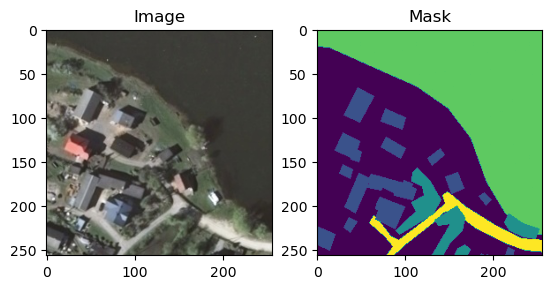

In [10]:
import random
from matplotlib import pyplot as plt

img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(os.path.join(img_dir, img_list[img_num]))
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot = tiff.imread(os.path.join(mask_dir, img_list[img_num]))

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
 
figure, axis = plt.subplots(1, 2)

axis[0].imshow(img_for_plot, vmin=0,vmax=100)
axis[0].set_title('Image')

axis[1].imshow(mask_for_plot)
axis[1].set_title('Mask')

plt.show()

1.5. Отсев неинформативных растров и соответствующих масок
Пропускаем изображения на которых один класс заднимает более 95% площади

In [14]:
useless=0

os.makedirs(r'datasets/landcover/256_patches/images_with_useful_info/images', exist_ok=True)
os.makedirs(r'datasets/landcover/256_patches/images_with_useful_info/masks', exist_ok=True)

for img in range(len(img_list)): 
    img_name=img_list[img]
    mask_name = msk_list[img]
      
    temp_image=tiff.imread(os.path.join(img_dir ,img_list[img]))
   
    temp_mask=tiff.imread(os.path.join(mask_dir ,msk_list[img]))
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.05:  # От 5% полезной площади
        tiff.imwrite(os.path.join(r'datasets/landcover/256_patches/images_with_useful_info/images', img_name), temp_image, photometric='rgb')
        tiff.imwrite(os.path.join(r'datasets/landcover/256_patches/images_with_useful_info/masks', mask_name), temp_mask, photometric='minisblack')
        
    else:
        useless +=1

print("Total useful images are: ", len(img_list)-useless)
print("Total useless images are: ", useless)

Total useful images are:  21924
Total useless images are:  19722


1.6. Формирование папок с обучающей и валидационной выборкой

In [15]:
import splitfolders

input_folder = 'datasets/landcover/256_patches/images_with_useful_info'
output_folder = 'datasets/landcover/data_for_training'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None)

Copying files: 43848 files [00:22, 1919.57 files/s]


In [17]:
import shutil

src_train_img = 'datasets/landcover/data_for_training/train/images'
src_train_msk = 'datasets/landcover/data_for_training/train/masks'
src_val_img   = 'datasets/landcover/data_for_training/val/images'
src_val_msk   = 'datasets/landcover/data_for_training/val/masks'

dst_train_img = 'datasets/landcover/dataset/train_image/train/'
dst_train_msk = 'datasets/landcover/dataset/train_mask/train/'
dst_val_img   = 'datasets/landcover/dataset/val_image/val/'
dst_val_msk   = 'datasets/landcover/dataset/val_mask/val/'

shutil.copytree(src_train_img, dst_train_img)
shutil.copytree(src_train_msk, dst_train_msk)
shutil.copytree(src_val_img, dst_val_img)
shutil.copytree(src_val_msk, dst_val_msk)


Этап 2. Загрузка тренировочной и тестовой выборки. Подготовка к обучению. Разработка архитектуры модели нейронной сети

2.1. Инициализация сформированной выборки

In [27]:
train_img_dir = 'datasets/landcover/dataset/train_image/train/'
train_mask_dir = 'datasets/landcover/dataset/train_mask/train/'

val_img_dir = 'datasets/landcover/dataset/val_image/val/'
val_mask_dir = 'datasets/landcover/dataset/val_mask/val/'

img_list = sorted(os.listdir(train_img_dir))
msk_list = sorted(os.listdir(train_mask_dir))

num_images = len(os.listdir(train_img_dir))

print(f'Number of images: {num_images}')

Number of images: 16443


2.2. Предобработка обучающей выборки

In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

Нормализация исходного патча и маски

In [29]:
from tensorflow.keras.utils import to_categorical

def preprocess_data(img, mask, num_class):
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img) 
    mask = mask[:,:,:,0]
    mask = to_categorical(mask, num_class)
      
    return (img, mask)

2.3. Формирование последовательной загрузки набора данных с жесткого диска для обучения модели, используя Keras.ImageDataGenerator()

In [30]:
seed=24
batch_size=20
n_classes=5

In [31]:
from keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [35]:
train_img_path = 'datasets/landcover/dataset/train_image'
train_mask_path = 'datasets/landcover/dataset/train_mask'
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=n_classes)

val_img_path = r'datasets\landcover\dataset\val_image'
val_mask_path = r'datasets\landcover\dataset\val_mask'
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=n_classes)

Проверка

Found 16443 images belonging to 1 classes.
Found 16443 images belonging to 1 classes.
Found 5481 images belonging to 1 classes.
Found 5481 images belonging to 1 classes.
Train image shape: (20, 256, 256, 3)
Train mask shape: (20, 256, 256, 5)
Val image shape: (20, 256, 256, 3)
Val mask shape: (20, 256, 256, 5)


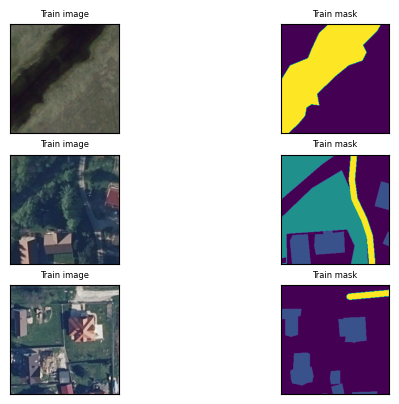

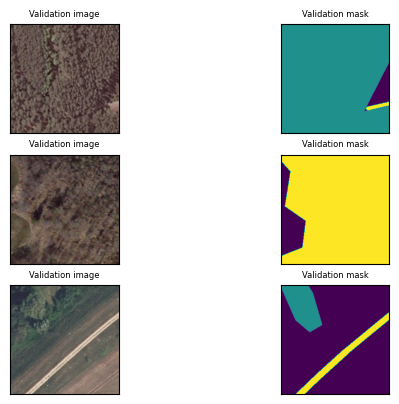

In [36]:
train_img_batch, train_mask_batch = next(train_img_gen)
train_mask_batch_argmax = np.argmax(train_mask_batch, axis=3) 

val_img_batch, val_mask_batch = next(val_img_gen)
val_mask_batch_argmax = np.argmax(val_mask_batch, axis=3) 

print(f'Train image shape: {train_img_batch.shape}')
print(f'Train mask shape: {train_mask_batch.shape}')
print(f'Val image shape: {val_img_batch.shape}')
print(f'Val mask shape: {val_mask_batch.shape}')

img_plot_count = 3

fig1, axis1 = plt.subplots(img_plot_count, 2)

for i in range(img_plot_count):
    axis1[i][0].imshow(train_img_batch[i])
    axis1[i][0].set_title('Train image', fontsize = 6)
    axis1[i][0].axes.xaxis.set_visible(False)
    axis1[i][0].axes.yaxis.set_visible(False)
    
    axis1[i][1].imshow(train_mask_batch_argmax[i])
    axis1[i][1].set_title('Train mask', fontsize = 6)
    axis1[i][1].axes.xaxis.set_visible(False)
    axis1[i][1].axes.yaxis.set_visible(False)

fig2, axis2 = plt.subplots(img_plot_count, 2)

for i in range(img_plot_count):
    axis2[i][0].imshow(val_img_batch[i])
    axis2[i][0].set_title('Validation image', fontsize = 6)
    axis2[i][0].axes.xaxis.set_visible(False)
    axis2[i][0].axes.yaxis.set_visible(False)
    
    axis2[i][1].imshow(val_mask_batch_argmax[i])
    axis2[i][1].set_title('Validation mask', fontsize = 6)
    axis2[i][1].axes.xaxis.set_visible(False)
    axis2[i][1].axes.yaxis.set_visible(False)

2.4. Разработка архитектуры и компиляция модели

In [38]:
from tensorflow.keras.optimizers import Adam

metrics = ['accuracy', sm.metrics.iou_score, sm.metrics.FScore()]
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

model.compile(optimizer=Adam(learning_rate=0.00001), loss=sm.losses.categorical_focal_dice_loss, metrics=metrics)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

Этап 3. Обучение модели и оценка точности

In [40]:
num_train_imgs = len(os.listdir('datasets/landcover/dataset/train_image/train'))
num_val_images = len(os.listdir('datasets/landcover/dataset/val_image/val'))

steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

print(f'Steps per epoch: {steps_per_epoch}')
print(f'Validation steps per epoch: {val_steps_per_epoch}')

Steps per epoch: 822
Validation steps per epoch: 274


In [41]:
history = model.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_img_gen,
    validation_steps=val_steps_per_epoch)

Epoch 1/10
822/822 [==============================] - 119s 136ms/step - loss: 0.7509 - accuracy: 0.6574 - iou_score: 0.1802 - f1-score: 0.2801 - val_loss: 0.9243 - val_accuracy: 0.2713 - val_iou_score: 0.0963 - val_f1-score: 0.1675
Epoch 2/10
822/822 [==============================] - 112s 136ms/step - loss: 0.5435 - accuracy: 0.8170 - iou_score: 0.3436 - f1-score: 0.4769 - val_loss: 0.4476 - val_accuracy: 0.8533 - val_iou_score: 0.4305 - val_f1-score: 0.5693
Epoch 3/10
822/822 [==============================] - 110s 134ms/step - loss: 0.4079 - accuracy: 0.8469 - iou_score: 0.4719 - f1-score: 0.6136 - val_loss: 0.3476 - val_accuracy: 0.8723 - val_iou_score: 0.5334 - val_f1-score: 0.6699
Epoch 4/10
822/822 [==============================] - 111s 135ms/step - loss: 0.3336 - accuracy: 0.8629 - iou_score: 0.5525 - f1-score: 0.6886 - val_loss: 0.2940 - val_accuracy: 0.8817 - val_iou_score: 0.5958 - val_f1-score: 0.7243
Epoch 5/10
822/822 [==============================] - 112s 136ms/step - 

In [42]:
model.save('models/landcover_unet_model.h5')

3.1 Визуализация процесса обучения

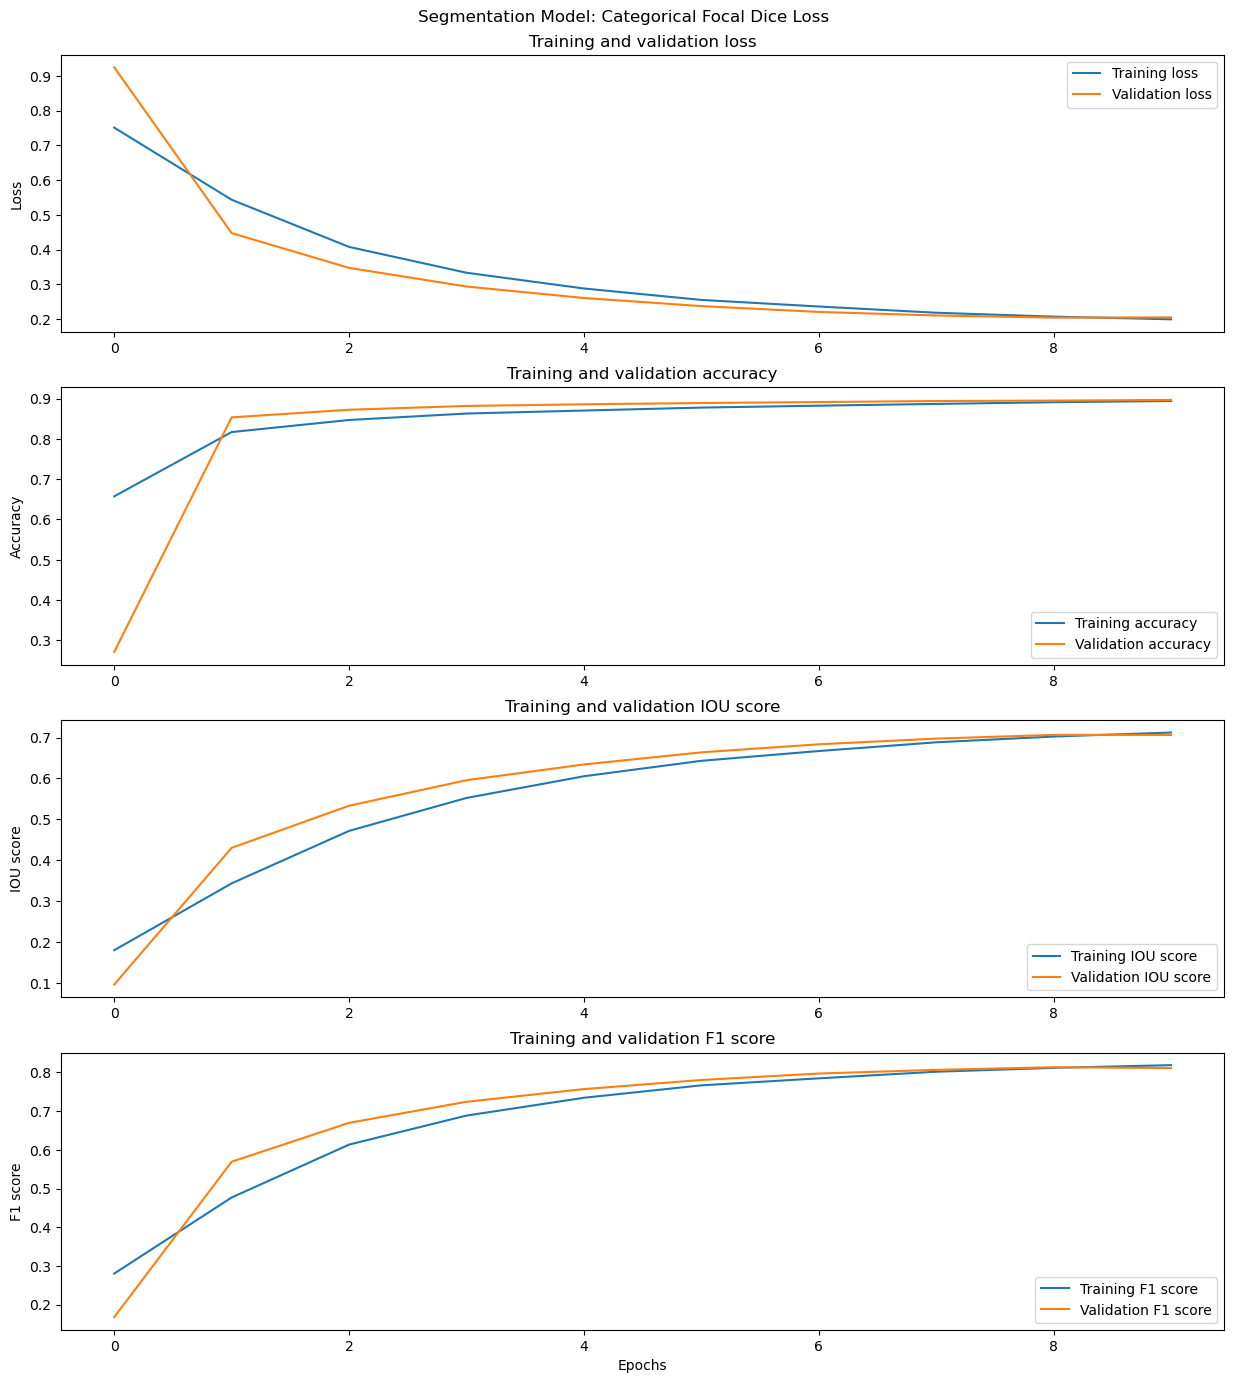

In [43]:
fig, axs = plt.subplots(4, 1)
    
fig.set_figwidth(15)
fig.set_figheight(15)
fig.suptitle("Segmentation Model: Categorical Focal Dice Loss")
plt.xlabel('Epochs', fontsize=10)
    
axs[0].set_title("Training and validation loss")
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_ylabel('Loss')
axs[0].legend(['Training loss', 'Validation loss'], loc="upper right")

axs[1].set_title("Training and validation accuracy")
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Training accuracy', 'Validation accuracy'], loc="lower right")

axs[2].set_title("Training and validation IOU score")
axs[2].plot(history.history['iou_score'])
axs[2].plot(history.history['val_iou_score'])
axs[2].set_ylabel('IOU score')
axs[2].legend(['Training IOU score', 'Validation IOU score'], loc="lower right")

axs[3].set_title("Training and validation F1 score")
axs[3].plot(history.history['f1-score'])
axs[3].plot(history.history['val_f1-score'])
axs[3].set_ylabel('F1 score')
_  = axs[3].legend(['Training F1 score', 'Validation F1 score'], loc="lower right")

fig.subplots_adjust(bottom=0.1, top=0.95)

3.2. Оценка оценка точности по валидационной выборке

In [44]:
from keras.models import load_model

metrics = ['accuracy', sm.metrics.iou_score, sm.metrics.FScore()]
model = load_model('models/landcover_unet_model.h5', compile=False)
model.compile(metrics=metrics)
test_pred_model = model.evaluate(val_img_gen, steps=num_val_images)

def print_model_evaluation(model_name, pred):
    print(f'Evaluation of {model_name}')
    print(F"Mean Accuracy = {pred[1]}") 
    print(F"Mean IOU = {pred[2]}") 
    print(F"Mean FScore = {pred[3]}") 
    print()

5481/5481 [==============================] - 546s 99ms/step - loss: 0.0000e+00 - accuracy: 0.8962 - iou_score: 0.7099 - f1-score: 0.8156


In [45]:
print_model_evaluation('Segmentation Model: Categorical Focal Dice Loss', test_pred_model)

Evaluation of Segmentation Model: Categorical Focal Dice Loss
Mean Accuracy = 0.89621502161026
Mean IOU = 0.7099231481552124
Mean FScore = 0.8155525326728821



3.3. Визуализация предсказаний и сравнение их с оригинальными масками

1/1 [==============================] - 1s 606ms/step


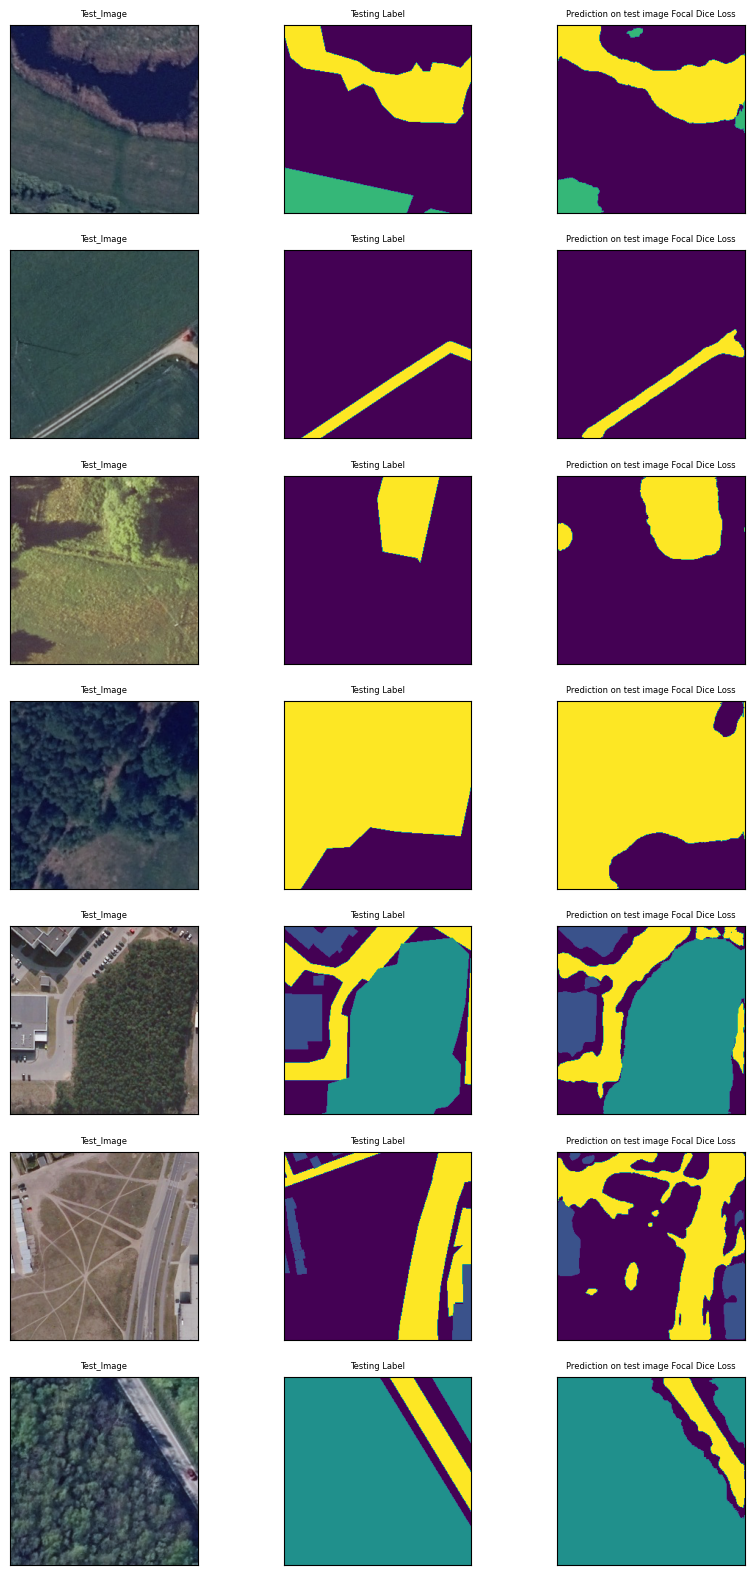

In [46]:
test_image_batch, test_mask_batch = val_img_gen.__next__()
test_image_batch = test_image_batch[:8,:,:,:]
test_mask_batch = test_mask_batch[:8,:,:,:]
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 

test_pred_batch_model = model.predict(test_image_batch)

test_pred_batch_model_argmax = np.argmax(test_pred_batch_model, axis=3)

fig, axis = plt.subplots(test_image_batch.shape[0]-1, 3)
fig.set_figwidth(10)
fig.set_figheight(20)

for img_num in range(test_image_batch.shape[0]-1):   
    
    axis[img_num][0].imshow(test_image_batch[img_num])
    axis[img_num][0].set_title('Test_Image', fontsize = 6)
    axis[img_num][0].axes.xaxis.set_visible(False)
    axis[img_num][0].axes.yaxis.set_visible(False)


    axis[img_num][1].imshow(test_mask_batch_argmax[img_num])
    axis[img_num][1].set_title("Testing Label", fontsize = 6)
    axis[img_num][1].axes.xaxis.set_visible(False)
    axis[img_num][1].axes.yaxis.set_visible(False)

    axis[img_num][2].imshow(test_pred_batch_model_argmax[img_num])
    axis[img_num][2].set_title("Prediction on test image Focal Dice Loss", fontsize = 6)
    axis[img_num][2].axes.xaxis.set_visible(False)
    axis[img_num][2].axes.yaxis.set_visible(False)

Этап 4. Обработка цельного снимка с помощью обученной модели

In [47]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import segmentation_models as sm
from keras.metrics import MeanIoU
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tifffile as tiff

In [48]:
"""

Original code is from the following source. It comes with MIT License so please mention
the original reference when sharing.

The original code has been modified to fix a couple of bugs and chunks of code
unnecessary for smooth tiling are removed. 

# MIT License
# Copyright (c) 2017 Vooban Inc.
# Coded by: Guillaume Chevalier
# Source to original code and license:
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches/blob/master/LICENSE

"""
"""Perform smooth predictions on an image from tiled prediction patches."""


import numpy as np
import scipy.signal
from tqdm import tqdm

import gc


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    PLOT_PROGRESS = False
    # See end of file for the rest of the __main__.
else:
    PLOT_PROGRESS = False


def _spline_window(window_size, power=2):
    """
    Squared spline (power=2) window function:
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
    """
    intersection = int(window_size/4)
    wind_outer = (abs(2*(scipy.signal.triang(window_size))) ** power)/2
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2*(scipy.signal.triang(window_size) - 1)) ** power)/2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind


cached_2d_windows = dict()
def _window_2D(window_size, power=2):
    """
    Make a 1D window function, then infer and return a 2D window function.
    Done with an augmentation, and self multiplication with its transpose.
    Could be generalized to more dimensions.
    """
    # Memoization
    global cached_2d_windows
    key = "{}_{}".format(window_size, power)
    if key in cached_2d_windows:
        wind = cached_2d_windows[key]
    else:
        wind = _spline_window(window_size, power)
        wind = np.expand_dims(np.expand_dims(wind, 1), 1)      #SREENI: Changed from 3, 3, to 1, 1 
        wind = wind * wind.transpose(1, 0, 2)
        if PLOT_PROGRESS:
            # For demo purpose, let's look once at the window:
            plt.imshow(wind[:, :, 0], cmap="viridis")
            plt.title("2D Windowing Function for a Smooth Blending of "
                      "Overlapping Patches")
            plt.show()
        cached_2d_windows[key] = wind
    return wind


def _pad_img(img, window_size, subdivisions):
    """
    Add borders to img for a "valid" border pattern according to "window_size" and
    "subdivisions".
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    more_borders = ((aug, aug), (aug, aug), (0, 0))
    ret = np.pad(img, pad_width=more_borders, mode='reflect')
    # gc.collect()

    if PLOT_PROGRESS:
        # For demo purpose, let's look once at the window:
        plt.imshow(ret)
        plt.title("Padded Image for Using Tiled Prediction Patches\n"
                  "(notice the reflection effect on the padded borders)")
        plt.show()
    return ret


def _unpad_img(padded_img, window_size, subdivisions):
    """
    Undo what's done in the `_pad_img` function.
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    ret = padded_img[
        aug:-aug,
        aug:-aug,
        :
    ]
    # gc.collect()
    return ret


def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return mirrs


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return np.mean(origs, axis=0)


def _windowed_subdivs(padded_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Create tiled overlapping patches.
    Returns:
        5D numpy array of shape = (
            nb_patches_along_X,
            nb_patches_along_Y,
            patches_resolution_along_X,
            patches_resolution_along_Y,
            nb_output_channels
        )
    Note:
        patches_resolution_along_X == patches_resolution_along_Y == window_size
    """
    WINDOW_SPLINE_2D = _window_2D(window_size=window_size, power=2)

    step = int(window_size/subdivisions)
    padx_len = padded_img.shape[0]
    pady_len = padded_img.shape[1]
    subdivs = []

    for i in range(0, padx_len-window_size+1, step):
        subdivs.append([])
        for j in range(0, pady_len-window_size+1, step):            #SREENI: Changed padx to pady (Bug in original code)
            patch = padded_img[i:i+window_size, j:j+window_size, :]
            subdivs[-1].append(patch)

    # Here, `gc.collect()` clears RAM between operations.
    # It should run faster if they are removed, if enough memory is available.
    gc.collect()
    subdivs = np.array(subdivs)
    gc.collect()
    a, b, c, d, e = subdivs.shape
    subdivs = subdivs.reshape(a * b, c, d, e)
    gc.collect()

    subdivs = pred_func(subdivs)
    gc.collect()
    subdivs = np.array([patch * WINDOW_SPLINE_2D for patch in subdivs])
    gc.collect()

    # Such 5D array:
    subdivs = subdivs.reshape(a, b, c, d, nb_classes)
    gc.collect()

    return subdivs


def _recreate_from_subdivs(subdivs, window_size, subdivisions, padded_out_shape):
    """
    Merge tiled overlapping patches smoothly.
    """
    step = int(window_size/subdivisions)
    padx_len = padded_out_shape[0]
    pady_len = padded_out_shape[1]

    y = np.zeros(padded_out_shape)

    a = 0
    for i in range(0, padx_len-window_size+1, step):
        b = 0
        for j in range(0, pady_len-window_size+1, step):                #SREENI: Changed padx to pady (Bug in original code)
            windowed_patch = subdivs[a, b]
            y[i:i+window_size, j:j+window_size] = y[i:i+window_size, j:j+window_size] + windowed_patch
            b += 1
        a += 1
    return y / (subdivisions ** 2)


def predict_img_with_smooth_windowing(input_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Apply the `pred_func` function to square patches of the image, and overlap
    the predictions to merge them smoothly.
    See 6th, 7th and 8th idea here:
    http://blog.kaggle.com/2017/05/09/dstl-satellite-imagery-competition-3rd-place-winners-interview-vladimir-sergey/
    """
    pad = _pad_img(input_img, window_size, subdivisions)
    pads = _rotate_mirror_do(pad)

    # Note that the implementation could be more memory-efficient by merging
    # the behavior of `_windowed_subdivs` and `_recreate_from_subdivs` into
    # one loop doing in-place assignments to the new image matrix, rather than
    # using a temporary 5D array.

    # It would also be possible to allow different (and impure) window functions
    # that might not tile well. Adding their weighting to another matrix could
    # be done to later normalize the predictions correctly by dividing the whole
    # reconstructed thing by this matrix of weightings - to normalize things
    # back from an impure windowing function that would have badly weighted
    # windows.

    # For example, since the U-net of Kaggle's DSTL satellite imagery feature
    # prediction challenge's 3rd place winners use a different window size for
    # the input and output of the neural net's patches predictions, it would be
    # possible to fake a full-size window which would in fact just have a narrow
    # non-zero dommain. This may require to augment the `subdivisions` argument
    # to 4 rather than 2.

    res = []
    for pad in tqdm(pads):
        # For every rotation:
        sd = _windowed_subdivs(pad, window_size, subdivisions, nb_classes, pred_func)
        one_padded_result = _recreate_from_subdivs(
            sd, window_size, subdivisions,
            padded_out_shape=list(pad.shape[:-1])+[nb_classes])

        res.append(one_padded_result)

    # Merge after rotations:
    padded_results = _rotate_mirror_undo(res)

    prd = _unpad_img(padded_results, window_size, subdivisions)

    prd = prd[:input_img.shape[0], :input_img.shape[1], :]

    if PLOT_PROGRESS:
        plt.imshow(prd)
        plt.title("Smoothly Merged Patches that were Tiled Tighter")
        plt.show()
    return prd

In [52]:
test_img_dir = 'datasets/landcover/images'
test_mask_dir = 'datasets/landcover/masks'

test_img_list = [r"N-34-97-D-c-2-4.tif"]
test_mask_list = [r"N-34-97-D-c-2-4.tif"]

test_num_images = len(test_img_list)

In [53]:
from keras.models import load_model

unet_model = load_model('models/landcover_unet_model.h5', compile=False)
                  
patch_size = 256

n_classes = 5
predicted_masks = []
for imagePath in test_img_list:
    img = cv2.imread(os.path.join(test_img_dir, imagePath), 1)

    input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    predictions_smooth = predict_img_with_smooth_windowing(
        input_img,
        window_size=patch_size,
        subdivisions=2, 
        nb_classes=n_classes,
        pred_func=(
            lambda img_batch_subdiv: unet_model.predict((img_batch_subdiv))
        )
    )

    final_prediction = np.argmax(predictions_smooth, axis=2)
    predicted_masks.append(final_prediction)

  0%|          | 0/8 [00:00<?, ?it/s]

40/40 [==============================] - 2s 33ms/step


 12%|█▎        | 1/8 [00:07<00:53,  7.69s/it]

40/40 [==============================] - 1s 36ms/step


 25%|██▌       | 2/8 [00:15<00:47,  7.91s/it]

40/40 [==============================] - 1s 31ms/step


 38%|███▊      | 3/8 [00:22<00:37,  7.49s/it]

40/40 [==============================] - 1s 34ms/step


 50%|█████     | 4/8 [00:30<00:29,  7.40s/it]

40/40 [==============================] - 1s 35ms/step


 62%|██████▎   | 5/8 [00:36<00:21,  7.24s/it]

40/40 [==============================] - 1s 35ms/step


 75%|███████▌  | 6/8 [00:44<00:14,  7.32s/it]

40/40 [==============================] - 1s 33ms/step


 88%|████████▊ | 7/8 [00:51<00:07,  7.20s/it]

40/40 [==============================] - 1s 35ms/step


100%|██████████| 8/8 [00:58<00:00,  7.36s/it]


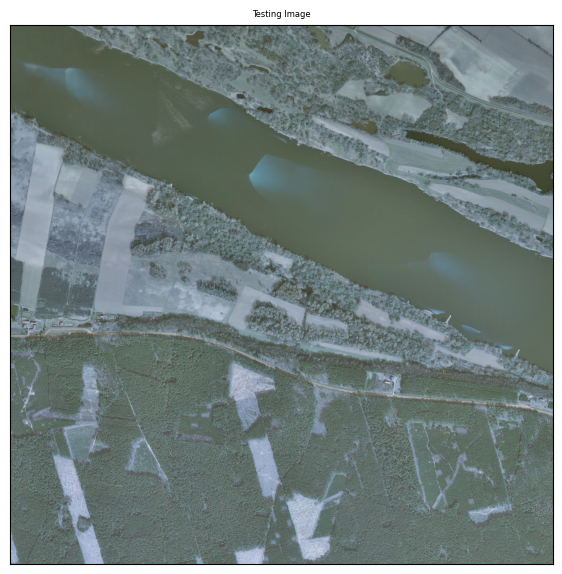

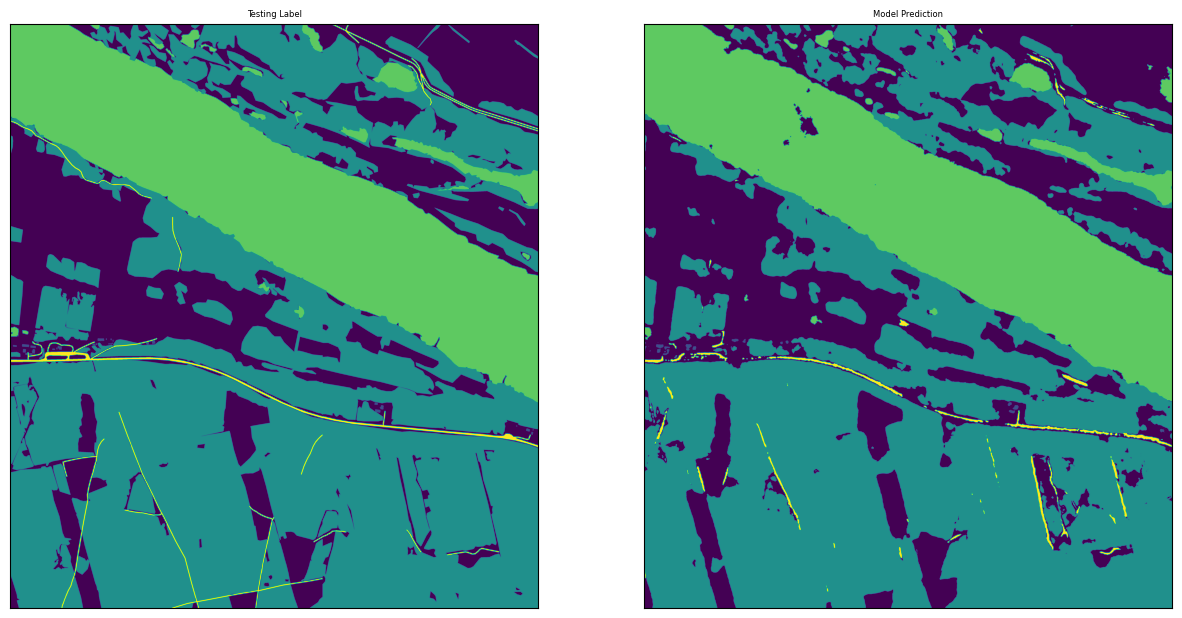

In [54]:
img_num = 0

fig, plot = plt.subplots(1, 1, figsize=(7.,7.))

test_image = cv2.imread(os.path.join(test_img_dir, test_img_list[img_num]), 1)
plot.imshow(test_image, aspect='auto', extent=(20, 80, 20, 80),)
plot.set_title("Testing Image", fontsize = 6)
plot.axes.xaxis.set_visible(False)
plot.axes.yaxis.set_visible(False)

fig, axis = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(20)


test_mask = tiff.imread(os.path.join(test_mask_dir, test_mask_list[img_num]))
axis[0].imshow(test_mask)
axis[0].set_title("Testing Label", fontsize = 6)
axis[0].axes.xaxis.set_visible(False)
axis[0].axes.yaxis.set_visible(False)

axis[1].imshow(predicted_masks[img_num])
axis[1].set_title("Model Prediction", fontsize = 6)
axis[1].axes.xaxis.set_visible(False)
axis[1].axes.yaxis.set_visible(False)